In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from google.colab import drive
import os
import glob
from astropy.wcs import WCS
from astropy.table import Table
from scipy.integrate import quad
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install photutils
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats, Aperture

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.8 MB/s eta 0:00:00


In [3]:
!pip install sep
import sep

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.3 MB/s eta 0:00:00


In [4]:
!pip install reproject

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.8/378.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 69.8 MB/s eta 0:00:00
  Created wheel for pims: filename=PIMS-0.7-py3-none-any.whl size=84590 sha256=0c0810d1aed26b1c5a44c6775cff87ca97549bf02f77389e4a48b794ad70d594
  Stored in directory: /root/.cache/pip/wheels/be/9c/72/7cb84823aaa980c2e44064caae0ba869239270fac14f7129aa
Successfully built pims


In [5]:
from reproject import reproject_interp
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

In [7]:
drive.mount('/content/drive/', force_remount=True)
path = "/content/drive/My Drive/Data Acquisition"

Mounted at /content/drive/


# Calibration

- Bias: legato al voltaggio (..) --> il suo livello è settabile con un "off-set"
- read-out-noise: quanto velocemnte vengono letti i conteggi ma non legato al BIas in modo esplicito o lineare (più veloce viene letto un detector più alto il read-out-noise). Lo vuoi più basso possibile.
Fisicamente: la varianza di tutti i pixel (roba gaussiana di com'è distribuito il read-out-noise(o del bias) per ogni pixel, perchè è diverso) è il read-out-noise al quadrato (quindi la standar deviation eè il read-out-noise)

In [8]:
def f_BIAS():
  path_b = "/content/drive/My Drive/Data Acquisition/TelescopeData/NEW CAMERA/2025-09-25/BIAS"
  image_data = np.zeros((3194,4788))
  for filename in os.listdir(path_b):
    filepath = os.path.join(path_b, filename)
    open(filepath)
    hdul = fits.open(filepath)
    image_data = image_data + hdul[0].data
    hdul.close()
  BIAS = image_data/len(os.listdir(path_b))
  return BIAS


def f_FLAT(filter, BIAS):
  path_flat = "/content/drive/My Drive/Data Acquisition/TelescopeData/NEW CAMERA/2025-10-01/FLAT"
  flat_list = glob.glob(path_flat + f'/*{filter}*.fits')
  matrix = np.zeros((len(flat_list),3194,4788))
  n = 0
  for filename in flat_list:
    open(filename)
    hdul = fits.open(filename)
    matrix[n,:,:] = hdul[0].data - BIAS
    n = n + 1
    hdul.close()
  FLAT = np.median(matrix, axis=0)
  FLAT_norm = FLAT/np.median(FLAT)
  return FLAT_norm


def f_DARK(exposure, BIAS):
  path_dc = "/content/drive/My Drive/Data Acquisition/TelescopeData/NEW CAMERA/2025-09-25/DARK"
  dark_list = glob.glob(path_dc + f'/*{exposure}*.fits')
  dark_image = np.zeros((len(dark_list),3194,4788))
  n = 0
  for filename in dark_list:
    open(filename)
    hdul = fits.open(filename)
    dark_image[n,:,:] = hdul[0].data
    n = n + 1
    hdul.close()
  DARK = np.median(dark_image, axis=0) - BIAS
  return DARK

In [9]:
def f_gaia(filter):
  path_gaia = "/content/drive/My Drive/Data Acquisition/CalibrationStars/M103/GAIA3_509862066010920960.fits"
  hdul_gaia = fits.open(path_gaia)
  sim = Table.read(f"/content/drive/My Drive/Data Acquisition/{filter}_transmission.txt", format='ascii.basic')
  wav = sim["Wavelength(A)"]
  trans = sim["Transmission(QE*Filter)"] #efficienza di quanto passano bene gli elettroni
  trans_interp = np.interp(hdul_gaia[1].data, wav, trans)
  Num = np.trapezoid(hdul_gaia[0].data *trans_interp, hdul_gaia[1].data)
  Den = np.trapezoid(trans_interp, hdul_gaia[1].data)
  return Num/Den

In [10]:
def f_bkgsub(science, wcs, filter):
  gain = 0.25

  #from RA DEC in degrees to pixel position on the image
  pixpos = wcs.all_world2pix(23.38804096055661, 60.63702187961969, 1)
  x_center = int(pixpos[0])
  y_center = int(pixpos[1])
  sci_cut = science[(y_center-50):(y_center+50), (x_center-50):(x_center+50)]
  positions = [50, 50]
  aperture = CircularAperture(positions, r=15.0)
  annulus_aperture = CircularAnnulus(positions, r_in=20, r_out=30)

  aperstats = ApertureStats(sci_cut, annulus_aperture)
  bkg_mean = aperstats.mean
  phot_table = aperture_photometry(sci_cut, aperture)
  for col in phot_table.colnames:
      phot_table[col].info.format = '%.8g'

  aperture_area = aperture.area_overlap(sci_cut)
  total_bkg = bkg_mean * aperture_area
  phot_bkgsub = phot_table['aperture_sum'] - total_bkg
  phot_table['total_bkg'] = total_bkg
  phot_table['aperture_sum_bkgsub'] = phot_bkgsub
  for col in phot_table.colnames:
      phot_table[col].info.format = '%.8g'

  CC = eval(f'SynFlux_{filter}')/phot_bkgsub[0]
  return CC

In [11]:
#reference grid frame for image reprojection
npix = 4000
pix_size = 0.55
c = SkyCoord(["1:33:12 +60:42:00"], frame=FK4, unit=(u.hourangle, u.degree)) #M103 RA and Dec Sky Coordinate from hour and angle to degrees
ref_wcs = WCS(naxis=2)
ref_wcs.wcs.crval = [c[0].ra.degree, c[0].dec.degree]
ref_wcs.wcs.crpix = [npix / 2.0, npix / 2.0]
ref_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
ref_wcs.wcs.cunit = ['deg', 'deg']
scale_deg = pix_size / 3600.0
ref_wcs.wcs.cd = [[-scale_deg, 0], [0, scale_deg]]

In [12]:
BIAS = f_BIAS()
FLAT_R = f_FLAT('_R_', BIAS)
FLAT_G = f_FLAT('_G_', BIAS)
FLAT_I = f_FLAT('_I_', BIAS)
DARK_300 = f_DARK('_300.00s_', BIAS)
DARK_600 = f_DARK('_600.00s_', BIAS)
SynFlux_R = f_gaia('R')
SynFlux_G = f_gaia('G')
SynFlux_I = f_gaia('I')

In [13]:
print(SynFlux_R, SynFlux_G, SynFlux_I)

3.927128091939314e-14 6.178855168672088e-14 2.5126455686926647e-14


In [14]:
filter = 'R'
print(f'SynFlux_{filter}')
print(eval(f'SynFlux_{filter}'))

SynFlux_R
3.927128091939314e-14


Salvo a Disco Bias, Flat per ogni fitro, Dark per ogni exposure time e Syntetic Flux per ogni filtro così non li deve calcolare per ogni immagine ma li ha già!

# Work on the data

In [15]:
gain = 0.25

def f_data(date, M103, filter, exposure, BIAS):
  path_raw = f"/content/drive/My Drive/Data Acquisition/TelescopeData/NEW CAMERA/{date}/LIGHT/"
  raw_list = glob.glob(path_raw + '{}*{}*_{}_*{}*.fits'.format(date,M103,filter,exposure))
  reprojected_images = []
  tot_science = []
  tot_CC = []
  for filename in raw_list:
    hdul = fits.open(filename)
    raw = hdul[0].data
    wcs = WCS(hdul[0].header)
    hdul.close()
    science = (raw - (BIAS + eval(f'DARK_{exposure}'))) / eval(f'FLAT_{filter}')
    science = science * gain / float(exposure)

    #calibration constant
    science = science * (f_bkgsub(science, wcs, filter)) *10**16
    tot_CC.append(f_bkgsub(science, wcs, filter))
    #*10**16 perchè sono numeri troppo piccoli per il computer
    #print(science)

    #sky subtraction
    sci_shift = science - np.median(science.flatten())
    objects, mask = sep.extract(sci_shift, 1.5, err=np.std(sci_shift.flatten()), segmentation_map=True)
    bkg = sep.Background(sci_shift, mask=mask, bw=64, bh=64, fw=12, fh=12)
    science = science - bkg.back()
    #print(science)


    #image reprojection
    array_north_aligned, _ = reproject_interp((science, wcs), ref_wcs, shape_out=[npix,npix])
    reprojected_images.append(array_north_aligned)
    tot_science.append(science)

  reproj_data = np.median(reprojected_images, axis=0)
  sci_data = np.median(tot_science, axis=0)
  CC_data = np.mean(tot_CC)

  return reproj_data, sci_data, CC_data

In [16]:
R20251010_repro, R20251010_sci, R20251010_CC = f_data('2025-10-10','M103','R','300', BIAS)
G20251010_repro, G20251010_sci, G20251010_CC = f_data('2025-10-10','M103','G','300', BIAS)
I20251010_repro, I20251010_sci, I20251010_CC = f_data('2025-10-10','M103','I','300', BIAS)

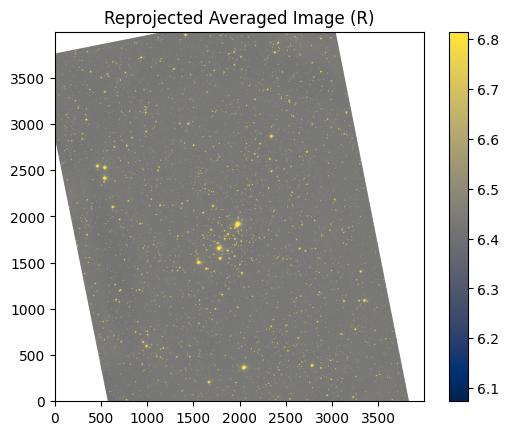

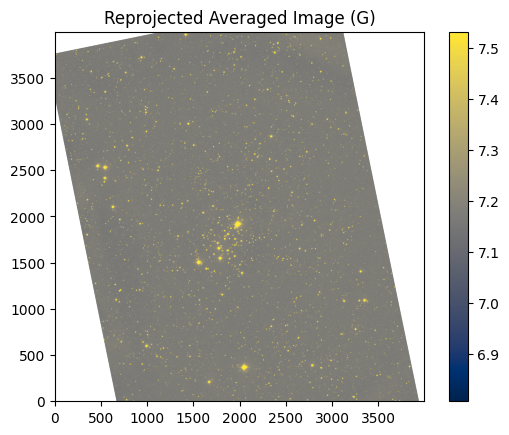

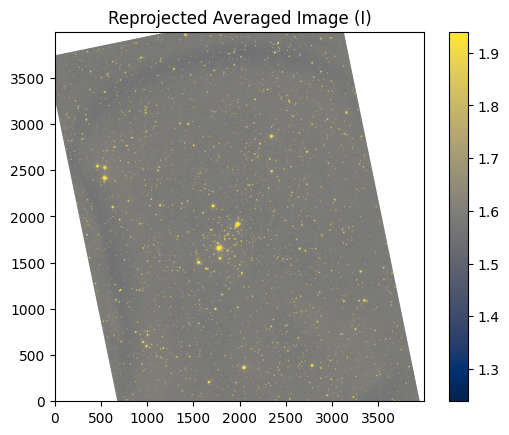

In [17]:
plt.imshow(R20251010_repro, cmap='cividis', vmin=np.mean(R20251010_sci)-2*np.std(R20251010_sci),
           vmax=np.mean(R20251010_sci)+2*np.std(R20251010_sci), origin='lower')
plt.title('Reprojected Averaged Image (R)')
plt.colorbar()
plt.savefig('/content/drive/My Drive/Data Acquisition/R20251010_repro.png')
plt.show()

plt.imshow(G20251010_repro, cmap='cividis', vmin=np.mean(G20251010_sci)-2*np.std(G20251010_sci),
           vmax=np.mean(G20251010_sci)+2*np.std(G20251010_sci), origin='lower')
plt.title('Reprojected Averaged Image (G)')
plt.colorbar()
plt.savefig('/content/drive/My Drive/Data Acquisition/G20251010_repro.png')
plt.show()

plt.imshow(I20251010_repro, cmap='cividis', vmin=np.mean(I20251010_sci)-2*np.std(I20251010_sci),
           vmax=np.mean(I20251010_sci)+2*np.std(I20251010_sci), origin='lower')
plt.title('Reprojected Averaged Image (I)')
plt.colorbar()
plt.savefig('/content/drive/My Drive/Data Acquisition/I20251010_repro.png')
plt.show()

In [18]:
print(np.nanmean(R20251010_repro))
print(np.nanmean(G20251010_repro))
print(np.nanmean(I20251010_repro))
print(np.nanstd(R20251010_repro))
print(np.nanstd(G20251010_repro))
print(np.nanstd(I20251010_repro))

6.448270105855288
7.190271348524416
1.6015974540359648
0.4258577084364952
0.4857069994913454
0.5366945329715648


In [19]:
print(R20251010_CC)
print(G20251010_CC)
print(I20251010_CC)

1.0000000000000001e-16
1.0000000000000012e-16
1.0000000000000002e-16


# Errors

In [20]:
path_member = "/content/drive/My Drive/Data Acquisition/M103_membership_selected.fits"
hdul_member = fits.open(path_member)
catalogue = Table.read(path_member)
#print(catalogue)

In [21]:
ref_wcs.all_world2pix(23.38804096055661, 60.63702187961969, 1)
pix_member = ref_wcs.all_world2pix(catalogue['RAdeg'], catalogue['DEdeg'], 1)
x_member = pix_member[0]
y_member = pix_member[1]

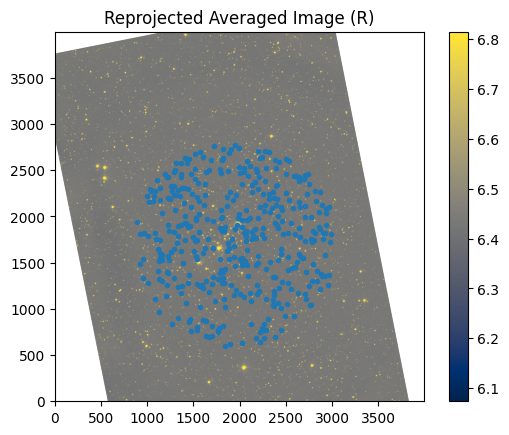

In [22]:
plt.imshow(R20251010_repro, cmap='cividis', vmin=np.mean(R20251010_sci)-2*np.std(R20251010_sci),
           vmax=np.mean(R20251010_sci)+2*np.std(R20251010_sci), origin='lower')
plt.plot(x_member,y_member,'.')
plt.title('Reprojected Averaged Image (R)')
plt.colorbar()
plt.show()

In [23]:
def f_fluxerr(science_repro, science_CC, exposure):
  new_hist = sigma_clip(science_repro.flatten(), sigma_lower=3, sigma_upper=3)
  fluxes = []
  errors = []

  for i in range(len(catalogue)):
    sci_cut = science_repro[(int(y_member[i])-50):(int(y_member[i])+50), (int(x_member[i])-50):(int(x_member[i])+50)]
    positions = [50, 50]
    aperture = CircularAperture(positions, r=15.0)
    phot_table = aperture_photometry(sci_cut, aperture)
    annulus_aperture = CircularAnnulus(positions, r_in=20, r_out=30)

    aperstats = ApertureStats(sci_cut, annulus_aperture)
    bkg_mean = aperstats.mean
    phot_table = aperture_photometry(sci_cut, aperture)

    aperture_area = aperture.area_overlap(sci_cut)
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    phot_table['total_bkg'] = total_bkg
    phot_table['aperture_sum_bkgsub'] = phot_bkgsub

    ap_sum = phot_table[0][5]
    N = np.pi * (aperture.r)**2 #(=aperture.area)

    #sigma b
    std_sci = np.std(new_hist)
    sigma_b = np.sqrt(N) * std_sci

    #sigma f
    sigma_f = np.sqrt((science_CC*10**16)/exposure) * np.sqrt(ap_sum)
    ERROR = np.sqrt(sigma_b**2 + sigma_f**2)

    fluxes.append(ap_sum)
    errors.append(ERROR)

  return fluxes, errors

In [24]:
flux_R, e_R = f_fluxerr(R20251010_repro, R20251010_CC,300)
flux_G, e_G = f_fluxerr(G20251010_repro, G20251010_CC, 300)
flux_I, e_I = f_fluxerr(I20251010_repro, I20251010_CC,300)

In [25]:
def flux_mag(fluxes, lamb):
  flux_nu = fluxes*((lamb**2)/(3*10**18))
  return -2.5*np.log10(flux_nu*10**-16) - 48.6

def mag_err(errors, fluxes):
  return (2.5/np.log(10))*errors/fluxes

In [26]:
mag_R = flux_mag(np.array(flux_R), 6500)
mag_G = flux_mag(np.array(flux_G), 4500)
mag_I = flux_mag(np.array(flux_I), 8000)
mag_err_R = mag_err(np.array(e_R), np.array(flux_R))
mag_err_G = mag_err(np.array(e_G), np.array(flux_G))
mag_err_I = mag_err(np.array(e_I), np.array(flux_I))

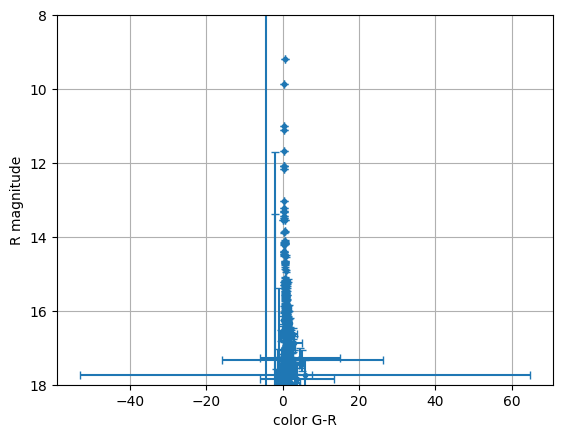

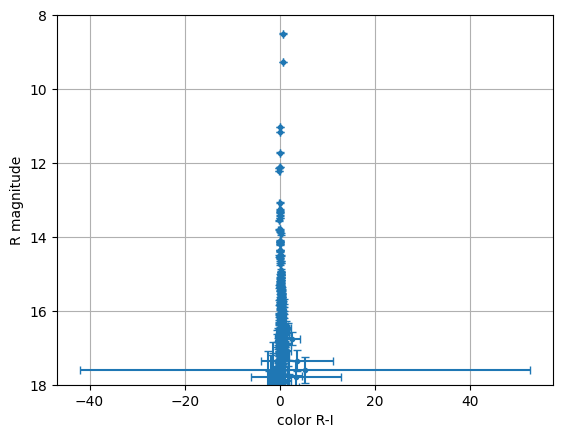

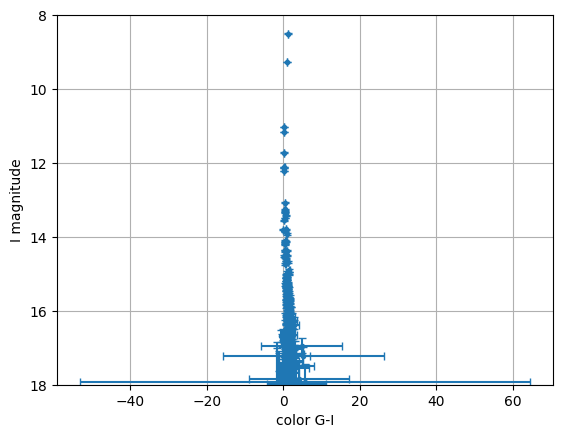

In [27]:

plt.plot(mag_G-mag_R, mag_R, '.')
plt.errorbar(mag_G-mag_R, mag_R, xerr=np.sqrt(mag_err_G**2 + mag_err_R**2), yerr=mag_err_R, fmt='none', capsize=3)
plt.xlabel('color G-R')
plt.ylabel('R magnitude')
plt.ylim(18,8)
plt.grid()
plt.show()
plt.plot(mag_R-mag_I, mag_I, '.')
plt.errorbar(mag_R-mag_I, mag_I, xerr=np.sqrt(mag_err_I**2 + mag_err_R**2), yerr=mag_err_I, fmt='none', capsize=3)
plt.ylim(18,8)
plt.xlabel('color R-I')
plt.ylabel('R magnitude')
plt.grid()
plt.show()
plt.plot(mag_G-mag_I, mag_I, '.')
plt.errorbar(mag_G-mag_I, mag_I, xerr=np.sqrt(mag_err_G**2 + mag_err_I**2), yerr=mag_err_I, fmt='none', capsize=3)
plt.ylim(18,8)
plt.xlabel('color G-I')
plt.ylabel('I magnitude')
plt.grid()
plt.show()

In [28]:
mag_err_G[(mag_err_G>1)] = 1
mag_err_R[(mag_err_R>1)] = 1
mag_err_I[(mag_err_I>1)] = 1
#mag_err_I[(mag_err_I==np.nan)] = 1

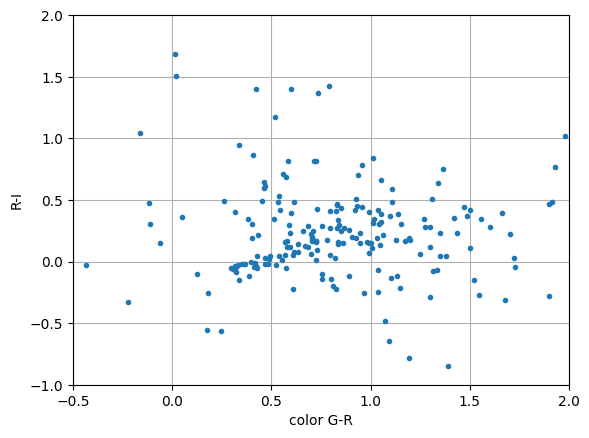

In [29]:
plt.plot(mag_G-mag_R, mag_R-mag_I, '.')
#plt.errorbar(mag_G-mag_R, mag_R-mag_I, xerr=np.sqrt(np.abs(mag_err_G**2 + mag_err_R**2)), yerr=np.sqrt(np.abs(mag_err_R**2 + mag_err_I**2)), fmt='none', capsize=3)
plt.xlabel('color G-R')
plt.ylabel('R-I')
plt.xlim(-0.5,2)
plt.ylim(-1,2)
plt.grid()
plt.show()

#Isochrones

NB: Conversione colori SDSS e TOBI sarebbe da fare ma i dati che abbiamo sono per le camere vecchie del telescopio quindi diciamo che sono tutti edue in SDSS

In [30]:
magG_cut = mag_G[mag_R < 17]
magR_cut = mag_R[mag_R < 17]
magI_cut = mag_I[mag_R < 17]
magerrG_cut = mag_err_G[mag_R < 17]
magerrR_cut = mag_err_R[mag_R < 17]
magerrI_cut = mag_err_I[mag_R < 17]


In [31]:
print(len(magG_cut), len(magI_cut), len(magR_cut))

153 153 153


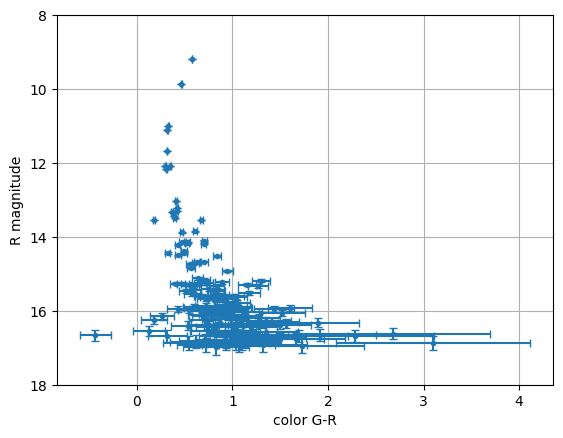

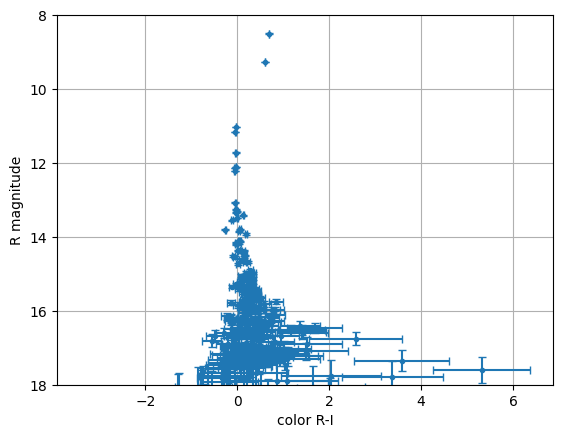

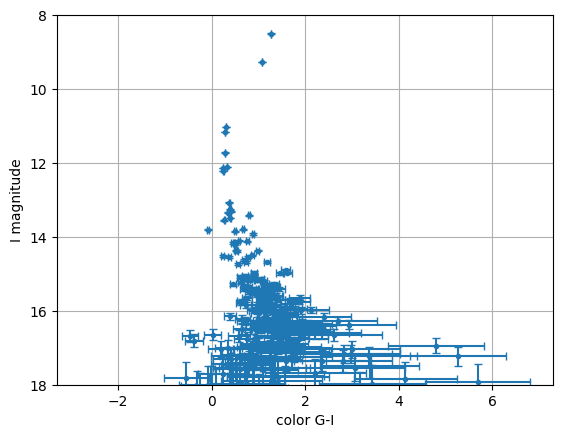

In [32]:
#con cut delle magintudini
plt.plot(magG_cut-magR_cut, magR_cut, '.')
plt.errorbar(magG_cut-magR_cut, magR_cut, xerr=np.sqrt(magerrG_cut**2 + magerrR_cut**2), yerr=magerrR_cut, fmt='none', capsize=3)
plt.xlabel('color G-R')
plt.ylabel('R magnitude')
plt.ylim(18,8)
plt.grid()
plt.show()

#senza cut delle magnitudini
plt.plot(mag_R-mag_I, mag_I, '.')
plt.errorbar(mag_R-mag_I, mag_I, xerr=np.sqrt(mag_err_I**2 + mag_err_R**2), yerr=mag_err_I, fmt='none', capsize=3)
plt.ylim(18,8)
plt.xlabel('color R-I')
plt.ylabel('R magnitude')
plt.grid()
plt.show()
plt.plot(mag_G-mag_I, mag_I, '.')
plt.errorbar(mag_G-mag_I, mag_I, xerr=np.sqrt(mag_err_G**2 + mag_err_I**2), yerr=mag_err_I, fmt='none', capsize=3)
plt.ylim(18,8)
plt.xlabel('color G-I')
plt.ylabel('I magnitude')
plt.grid()
plt.show()

In [33]:
path_isoc = "/content/drive/My Drive/Data Acquisition/isochrone_grid_parsec.dat"
isochrones = Table.read(path_isoc, format='ascii')
print(isochrones)

   Zini     MH  logAge     Mini       int_IMF    ...  zmag   Jmag   Hmag  Ksmag 
---------- ---- ------ ------------ ------------ ... ------ ------ ------ ------
0.00015547 -2.0    6.0 0.1000000015 1.1711064122 ...  6.172  4.973  4.346  4.182
0.00015547 -2.0    6.0 0.1027408764 1.1936023332 ...  6.141  4.943  4.318  4.155
0.00015547 -2.0    6.0 0.1060350239 1.2196285587 ...   6.13  4.936  4.314  4.152
0.00015547 -2.0    6.0 0.1081286743 1.2356298106 ...  6.128  4.936  4.316  4.155
0.00015547 -2.0    6.0  0.110455595 1.2529479109 ...  6.114  4.924  4.305  4.145
0.00015547 -2.0    6.0 0.1130246148 1.2715252705 ...  6.077  4.888  4.271  4.111
0.00015547 -2.0    6.0 0.1159230024 1.2918363457 ...  6.013  4.825  4.208  4.048
0.00015547 -2.0    6.0 0.1191874221 1.3139363826 ...  5.951  4.764  4.147  3.989
0.00015547 -2.0    6.0 0.1199999973 1.3193154249 ...  5.938  4.752  4.136  3.978
0.00015547 -2.0    6.0 0.1210087761 1.3259277739 ...  5.934  4.749  4.133  3.976
       ...  ...    ...      

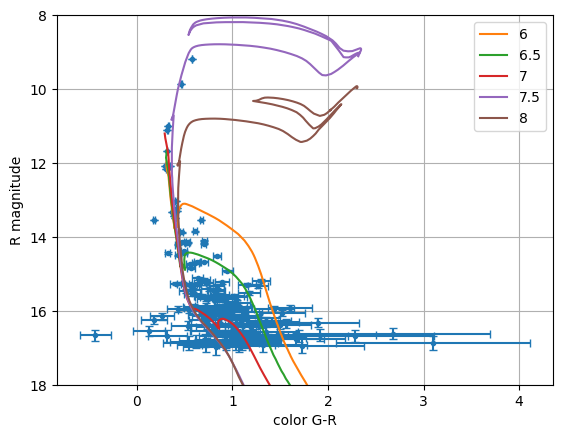

In [34]:
plt.plot(magG_cut-magR_cut, magR_cut, '.')
plt.errorbar(magG_cut-magR_cut, magR_cut, xerr=np.sqrt(magerrG_cut**2 + magerrR_cut**2), yerr=magerrR_cut, fmt='none', capsize=3)

age = [6,6.5,7,7.5,8]
for i in range(len(age)):
  iso_0MH = isochrones[(isochrones['MH'] == 0)&(isochrones['logAge'] == age[i])]
  iso_magG = iso_0MH['gmag']
  iso_magR = iso_0MH['rmag']
  iso_magI = iso_0MH['imag']
  plt.plot((iso_magG-iso_magR)+0.8, iso_magR+14, label=age[i])

plt.xlabel('color G-R')
plt.ylabel('R magnitude')
plt.ylim(18,8)
plt.legend()
plt.grid()
plt.show()

Ci concentriamo tra age 7 e 8 di 0.1 perchè sembrano i migliori fit

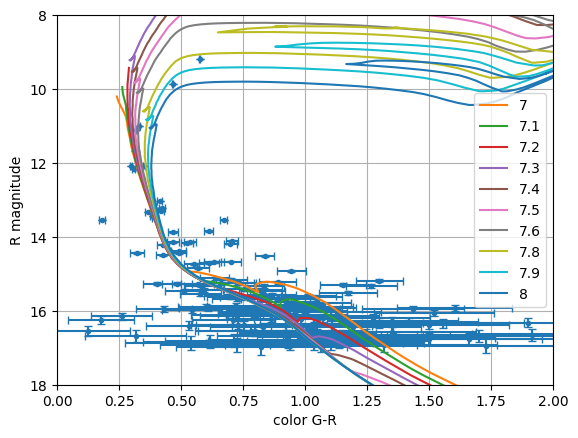

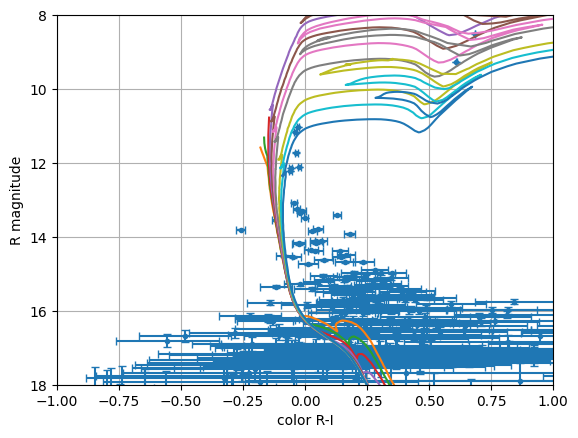

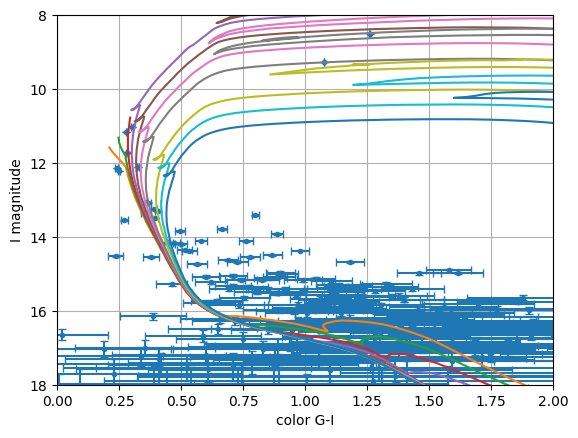

In [35]:
plt.plot(magG_cut-magR_cut, magR_cut, '.')
plt.errorbar(magG_cut-magR_cut, magR_cut, xerr=np.sqrt(magerrG_cut**2 + magerrR_cut**2), yerr=magerrR_cut, fmt='none', capsize=3)
age = [7,7.1,7.2,7.3,7.4,7.5,7.6,7.8,7.9,8]
for i in range(len(age)):
  iso_0MH = isochrones[(isochrones['MH'] == 0)&(isochrones['logAge'] == age[i])]
  iso_magG = iso_0MH['gmag']
  iso_magR = iso_0MH['rmag']
  iso_magI = iso_0MH['imag']
  plt.plot((iso_magG-iso_magR)+0.75, iso_magR+13, label=age[i])
plt.xlabel('color G-R')
plt.ylabel('R magnitude')
plt.ylim(18,8)
plt.xlim(0,2)
plt.legend()
plt.grid()
plt.show()

plt.plot(mag_R-mag_I, mag_I, '.')
plt.errorbar(mag_R-mag_I, mag_I, xerr=np.sqrt(mag_err_I**2 + mag_err_R**2), yerr=mag_err_I, fmt='none', capsize=3)
age = [7,7.1,7.2,7.3,7.4,7.5,7.6,7.8,7.9,8]
for i in range(len(age)):
  iso_0MH = isochrones[(isochrones['MH'] == 0)&(isochrones['logAge'] == age[i])]
  iso_magG = iso_0MH['gmag']
  iso_magR = iso_0MH['rmag']
  iso_magI = iso_0MH['imag']
  plt.plot((iso_magR-iso_magI)+0.2, iso_magI+14, label=age[i])
plt.ylim(18,8)
plt.xlim(-1,1)
plt.xlabel('color R-I')
plt.ylabel('R magnitude')
plt.grid()
plt.show()


plt.plot(mag_G-mag_I, mag_I, '.')
plt.errorbar(mag_G-mag_I, mag_I, xerr=np.sqrt(mag_err_G**2 + mag_err_I**2), yerr=mag_err_I, fmt='none', capsize=3)
age = [7,7.1,7.2,7.3,7.4,7.5,7.6,7.8,7.9,8]
for i in range(len(age)):
  iso_0MH = isochrones[(isochrones['MH'] == 0)&(isochrones['logAge'] == age[i])]
  iso_magG = iso_0MH['gmag']
  iso_magR = iso_0MH['rmag']
  iso_magI = iso_0MH['imag']
  plt.plot((iso_magG-iso_magI)+1.1, iso_magI+14, label=age[i])
plt.ylim(18,8)
plt.xlim(0,2)
plt.xlabel('color G-I')
plt.ylabel('I magnitude')
plt.grid()
plt.show()

# Brighter Stars

In [36]:
DARK_5 = 0

In [37]:
R20251010_repro_5, R20251010_sci_5, R20251010_CC_5 = f_data('2025-10-07','M103','R','5', BIAS)
G20251010_repro_5, G20251010_sci_5, G20251010_CC_5 = f_data('2025-10-07','M103','G','5', BIAS)
I20251010_repro_5, I20251010_sci_5, I20251010_CC_5 = f_data('2025-10-07','M103','I','5', BIAS)

In [39]:
flux_R_5, e_R_5 = f_fluxerr(R20251010_repro_5, R20251010_CC_5, 5)
flux_G_5, e_G_5 = f_fluxerr(G20251010_repro_5, G20251010_CC_5, 5)
flux_I_5, e_I_5 = f_fluxerr(I20251010_repro_5, I20251010_CC_5, 5)

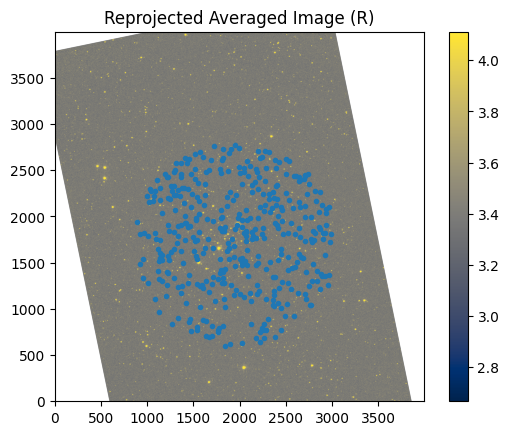

In [40]:
plt.imshow(R20251010_repro_5, cmap='cividis', vmin=np.mean(R20251010_sci_5)-2*np.std(R20251010_sci_5),
           vmax=np.mean(R20251010_sci_5)+2*np.std(R20251010_sci_5), origin='lower')
plt.plot(x_member,y_member,'.')
plt.title('Reprojected Averaged Image (R)')
plt.colorbar()
plt.show()

In [41]:
mag_R_5 = flux_mag(np.array(flux_R_5), 6500)
mag_G_5 = flux_mag(np.array(flux_G_5), 4500)
mag_I_5 = flux_mag(np.array(flux_I_5), 8000)
mag_err_R_5 = mag_err(np.array(e_R_5), np.array(flux_R_5))
mag_err_G_5 = mag_err(np.array(e_G_5), np.array(flux_G_5))
mag_err_I_5 = mag_err(np.array(e_I_5), np.array(flux_I_5))

In [42]:
mag_err_G_5[(mag_err_G_5>1)] = 1
mag_err_R_5[(mag_err_R_5>1)] = 1
mag_err_I_5[(mag_err_I_5>1)] = 1

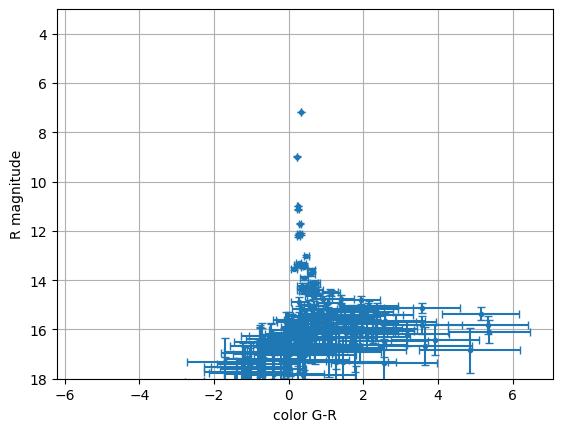

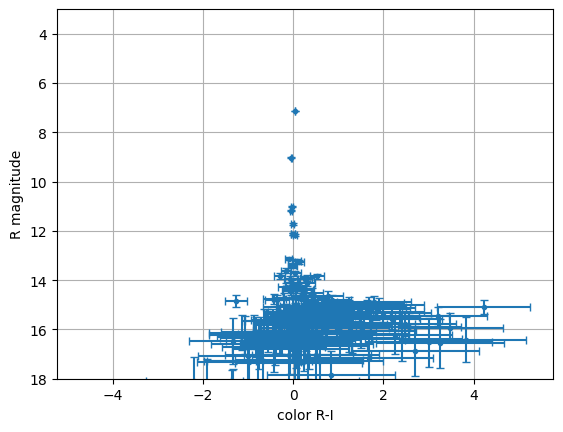

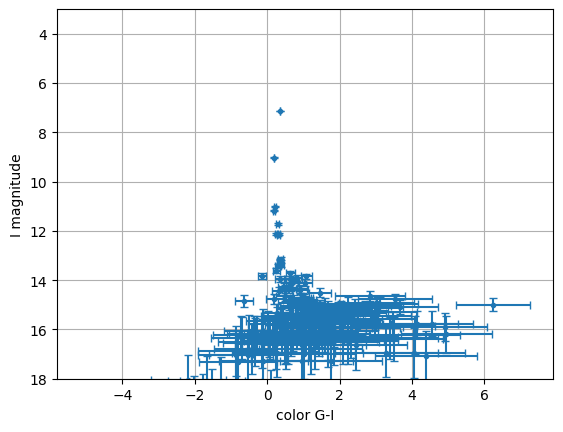

In [43]:
plt.plot(mag_G_5-mag_R_5, mag_R_5, '.')
plt.errorbar(mag_G_5-mag_R_5, mag_R_5, xerr=np.sqrt(mag_err_G_5**2 + mag_err_R_5**2), yerr=mag_err_R_5, fmt='none', capsize=3)
plt.ylim(18,3)
plt.xlabel('color G-R')
plt.ylabel('R magnitude')
plt.grid()
plt.show()
plt.plot(mag_R_5-mag_I_5, mag_I_5, '.')
plt.errorbar(mag_R_5-mag_I_5, mag_I_5, xerr=np.sqrt(mag_err_I_5**2 + mag_err_R_5**2), yerr=mag_err_I_5, fmt='none', capsize=3)
plt.ylim(18,3)
plt.xlabel('color R-I')
plt.ylabel('R magnitude')
plt.grid()
plt.show()
plt.plot(mag_G_5-mag_I_5, mag_I_5, '.')
plt.errorbar(mag_G_5-mag_I_5, mag_I_5, xerr=np.sqrt(mag_err_G_5**2 + mag_err_I_5**2), yerr=mag_err_I_5, fmt='none', capsize=3)
plt.ylim(18,3)
plt.xlabel('color G-I')
plt.ylabel('I magnitude')
plt.grid()
plt.show()

#FINAL DATA

In [44]:
MAG_G = np.concatenate((mag_G[mag_R >= 10], mag_G_5[mag_R_5 < 10]))
MAG_R = np.concatenate((mag_R[mag_R >= 10], mag_R_5[mag_R_5 < 10]))

MAG_I = np.concatenate((mag_I[mag_I >= 10], mag_I_5[mag_I_5 < 10]))
MAG_G_I = np.concatenate((mag_G[mag_I >= 10], mag_G_5[mag_I_5 < 10]))

MAG_ERR_G = np.concatenate((mag_err_G[mag_R >= 10], mag_err_G_5[mag_R_5 < 10]))
MAG_ERR_R = np.concatenate((mag_err_R[mag_R >= 10], mag_err_R_5[mag_R_5 < 10]))

MAG_ERR_I = np.concatenate((mag_err_I[mag_I >= 10], mag_err_I_5[mag_I_5 < 10]))
MAG_ERR_G_I = np.concatenate((mag_err_G[mag_I >= 10], mag_err_I_5[mag_I_5 < 10]))

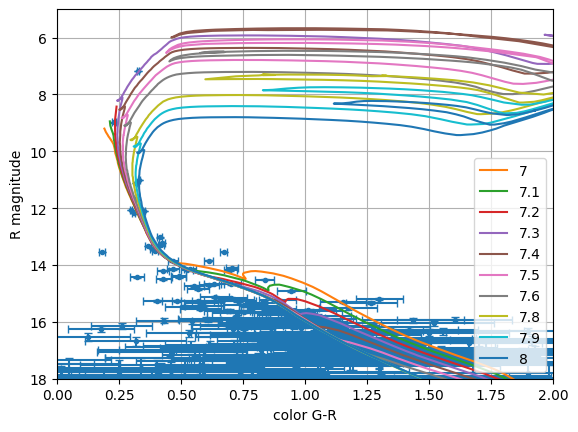

In [45]:
plt.plot(MAG_G-MAG_R, MAG_R, '.')
plt.errorbar(MAG_G-MAG_R, MAG_R, xerr=np.sqrt(MAG_ERR_G**2 + MAG_ERR_R**2), yerr=MAG_ERR_R, fmt='none', capsize=3)
age = [7,7.1,7.2,7.3,7.4,7.5,7.6,7.8,7.9,8]
for i in range(len(age)):
  iso_0MH = isochrones[(isochrones['MH'] == 0)&(isochrones['logAge'] == age[i])]
  iso_magG = iso_0MH['gmag']
  iso_magR = iso_0MH['rmag']
  iso_magI = iso_0MH['imag']
  plt.plot((iso_magG-iso_magR)+0.70, iso_magR+12, label=age[i])
plt.xlabel('color G-R')
plt.ylabel('R magnitude')
plt.ylim(18,5)
plt.xlim(0,2)
plt.legend()
plt.grid()
plt.show()

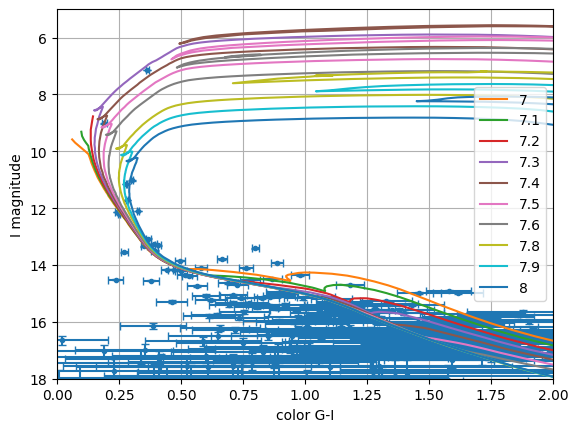

In [46]:
plt.plot(MAG_G_I-MAG_I, MAG_I, '.')
plt.errorbar(MAG_G_I-MAG_I, MAG_I, xerr=np.sqrt(MAG_ERR_G_I**2 + MAG_ERR_I**2), yerr=MAG_ERR_I, fmt='none', capsize=3)
age = [7,7.1,7.2,7.3,7.4,7.5,7.6,7.8,7.9,8]
for i in range(len(age)):
  iso_0MH = isochrones[(isochrones['MH'] == 0)&(isochrones['logAge'] == age[i])]
  iso_magG = iso_0MH['gmag']
  iso_magR = iso_0MH['rmag']
  iso_magI = iso_0MH['imag']
  plt.plot((iso_magG-iso_magI)+0.95, iso_magI+12, label=age[i])
plt.xlabel('color G-I')
plt.ylabel('I magnitude')
plt.ylim(18,5)
plt.xlim(0,2)
plt.legend()
plt.grid()
plt.show()